In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.plotting.register_matplotlib_converters()

import numpy as np
import seaborn as sns
import missingno as mgn

import plotly.express as px

Reading the data with standard preprocessing steps

In [2]:
# Just the new file only - for now
df1 = pd.read_excel('../data/data_d-drivers_2024-03-24.xlsx', sheet_name='data',
                    )
df2 = pd.read_excel('../data/data_d-drivers_2024-03-26.xlsx', sheet_name='data')

df1.columns = [col.lower() for col in df1.columns]
df2.columns = [col.lower() for col in df2.columns]

df1.rename({
           'impressions': 'page_impressions',
           'page_efahrer_id': 'page_id',
           'published_at': 'publish_date',
           'page_canonical_url': 'url',
           'page_author': 'authors', 
            }, axis=1, inplace=True)

df2.rename({
           'impressions': 'page_impressions',
           'page_efahrer_id': 'page_id',
           'published_at': 'publish_date',
           'page_canonical_url': 'url',
           'page_author': 'authors', 
            }, axis=1, inplace=True)

What makes each entry unique?

In [3]:
df1[df1[['page_id', 'date', 'url', 'authors', 'word_count']].duplicated(keep=False)] # keep=False keeps all duplicated values
                                    #.sort_values(['page_id', 'date', 'url', 'page_author'])

,page_id,date,publish_date,publish_date_equal_to_date,url,page_name,classification_product,classification_type,title,authors,daily_likes,daily_dislikes,word_count,video_play,clickouts,external_clicks,external_impressions
66544,1018299,2024-03-04,NaT,N,https://efahrer.chip.de/news/neuvorstellung-des-fiat-pandina-der-panda-bekommt-ein-geschwisterchen_1018299,efa-1018299 | Der Panda bekommt ein kleines Geschwisterchen: Neuvorstellung des Fiat Pandina,Auto,News,Neuvorstellung des Fiat Pandina: Der Panda bekommt ein Geschwisterchen - EFAHRER.com,JÃ¼rgen Wolff,NaN,NaN,NaN,41.0,0.0,23.0,771.0
78658,1018299,2024-03-04,NaT,N,https://efahrer.chip.de/news/neuvorstellung-des-fiat-pandina-der-panda-bekommt-ein-geschwisterchen_1018299,efa-1018299 | Der Panda bekommt ein kleines Geschwisterchen: Neuvorstellung des Fiat Pandina,Auto,News,Neuvorstellung des Fiat Pandina: Der Panda bekommt ein Geschwisterchen - EFAHRER.com,JÃ¼rgen Wolff,NaN,NaN,NaN,NaN,NaN,NaN,NaN


By experimenting with different sets of columns I found those are 

> 'page_id', 'date', 'url', 'authors', 'word_count'

* NOT the `page_name`: it is totally broken
* NOT the `publish_date`: sometimes the articles changed several times during the day and the word count changed, so `publish_date` does not capture all combinations

Addressing the rows by all of those columns makes every article unique but just a single one: 1018299 (rows 66544 and 78658). But the second entry is just a mistake with all missing values, it can be simply dropped. 

In [4]:
df1.drop(78658, inplace=True)

Merge on those:

In [5]:
key_columns = ['page_id', 'date', 'url', 'authors', 'word_count']

What columns are in `df1` and not in `df2`?

In [6]:
print(df2.columns.difference(df1.columns))
print(df1.columns.difference(df2.columns))

Index(['page_impressions'], dtype='object')
Index(['clickouts'], dtype='object')


So the page impressions only present in the 2nd delivery, and clockouts only in the first delivery. 
We will merge the *first to the second*, so in the first dataset we only want to have the key columns and the unique one.

In [7]:
df1 = df1[key_columns + ['clickouts']]

What pages are in df1 and not in df2 and the other way around?

In [8]:
print(df1.set_index('page_id').index.difference(df2.set_index('page_id').index))
print(df2.set_index('page_id').index.difference(df1.set_index('page_id').index))

Index([], dtype='int64', name='page_id')
Index([1018667, 1018673, 1018687, 1018743, 1018770, 1018771, 1018776, 1018782], dtype='int64', name='page_id')


> The new data delivery includes all pages from the first one + 8 new ones.

What `URLs` are in df1 and not in df2 and the other way around?

In [9]:
print(df1.set_index('url').index.difference(df2.set_index('url').index))
print(df2.set_index('url').index.difference(df1.set_index('url').index))

Index([], dtype='object', name='url')
Index(['https://efahrer.chip.de/news/4-module-optionaler-speicher-haendler-setzt-balkonkraftwerk-auf-799-euro-runter_1017455',
       'https://efahrer.chip.de/news/ampeln-mit-neuer-farbe-weiss-will-das-leben-aller-verkehrsteilnehmer-verbessern_1011583',
       'https://efahrer.chip.de/news/angebot-nur-bis-ostern-so-bekommen-sie-1000-euro-rabatt-auf-ihre-solaranlage_1018573',
       'https://efahrer.chip.de/news/auch-mit-halterung-bei-diesem-balkonkraftwerk-preis-schlucken-selbst-discounter_1014858',
       'https://efahrer.chip.de/news/batterie-geheimnisse-maenner-sollen-tesla-bestohlen-und-firma-gegruendet-haben_1018770',
       'https://efahrer.chip.de/news/buegelschloss-mit-fingerabdrucksensor-bei-aldi_1013493',
       'https://efahrer.chip.de/news/dashcam-schnaeppchen-bei-amazon-das-taugt-die-kamera-fuer-unter-40-euro_1018667',
       'https://efahrer.chip.de/news/e-auto-fahrer-sind-fein-raus-deutsches-gericht-erzwingt-schaerfere-fahrverbote_10

> 22 new URLs

Which dates are new?

In [10]:
print(df1.set_index('date').index.difference(df2.set_index('date').index))
print(df2.set_index('date').index.difference(df1.set_index('date').index))

DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)
DatetimeIndex(['2024-03-23'], dtype='datetime64[ns]', name='date', freq=None)


> The day between the first and the second data deliveries, makes a lot of sense :D

In [11]:
if df1.shape == df1.drop_duplicates().shape:
    print('No duplicates left in the first dataframe')
else: 
    print('Duplicated entries present: merging will blow up the data frame size')

No duplicates left in the first dataframe


In [12]:
if df2[key_columns].shape == df2[key_columns].drop_duplicates().shape:
    print('No duplicates are in the second dataframe')
else: 
    print('Duplicated entries present: merging will blow up the data frame size')

Duplicated entries present: merging will blow up the data frame size


In [13]:
df2[df2[key_columns].duplicated(keep=False)] # keep=False keeps all duplicated values
                                    #.sort_values(['page_id', 'date', 'url', 'page_author'])

,page_id,date,publish_date,publish_date_equal_to_date,url,page_name,classification_product,classification_type,title,authors,daily_likes,daily_dislikes,word_count,video_play,page_impressions,external_clicks,external_impressions
40600,1018299,2024-03-04,NaT,N,https://efahrer.chip.de/news/neuvorstellung-des-fiat-pandina-der-panda-bekommt-ein-geschwisterchen_1018299,efa-1018299 | Der Panda bekommt ein kleines Geschwisterchen: Neuvorstellung des Fiat Pandina,Auto,News,Der Panda bekommt ein kleines Geschwisterchen: Neuvorstellung des Fiat Pandina,Jürgen Wolff,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107004,1018299,2024-03-04,NaT,N,https://efahrer.chip.de/news/neuvorstellung-des-fiat-pandina-der-panda-bekommt-ein-geschwisterchen_1018299,efa-1018299 | Der Panda bekommt ein kleines Geschwisterchen: Neuvorstellung des Fiat Pandina,Auto,News,Der Panda bekommt ein kleines Geschwisterchen: Neuvorstellung des Fiat Pandina,Jürgen Wolff,NaN,NaN,NaN,41.0,72.0,23.0,771.0


Same mistake is in `df2`: remove it.

In [14]:
df2.drop(40600, inplace=True)

In [15]:
if df2[key_columns].shape == df2[key_columns].drop_duplicates().shape:
    print('No duplicates are in the second dataframe')
else: 
    print('Duplicated entries present: merging will blow up the data frame size')

No duplicates are in the second dataframe


Yuppi, now we are ready to merge!

## Merging

Using the `left` merging: we already know that `df1` is malformatted

In [16]:
df = pd.merge(left=df2, right=df1, on=key_columns, how='left') 
# in principle, even the page_id is redundant in this case, 
# because each url contains the page id as the suffix

df

,page_id,date,publish_date,publish_date_equal_to_date,url,page_name,classification_product,classification_type,title,authors,daily_likes,daily_dislikes,word_count,video_play,page_impressions,external_clicks,external_impressions,clickouts
0,1010803,2023-01-02,NaT,N,https://efahrer.chip.de/news/tariferhoehungen-und-thg-praemie-ladesaeulenbetreiber-ziehen-kunden-ueber-den-tisch_1010803,efa-1010803 | Tariferhöhungen und THG-Prämie: Ladesäulenbetreiber ziehen Kunden über den Tisch,THG,News,Tariferhöhungen und THG-Prämie: Ladesäulenbetreiber ziehen Kunden über den Tisch,Karl Lüdecke,NaN,NaN,NaN,1261.0,1375.0,1301.0,20323.0,NaN
1,1010592,2023-01-02,NaT,N,https://efahrer.chip.de/news/das-logo-von-alfa-romeo-wofuer-stehen-schlange-und-kreuz_1010592,efa-1010592 | Alfa Romeo: Was bedeuten Schlange und Kreuz?,Auto,News,Alfa Romeo: Was bedeuten Schlange und Kreuz?,Karl Müller,NaN,NaN,NaN,286.0,298.0,164.0,1493.0,NaN
2,1010719,2023-01-05,NaT,N,https://efahrer.chip.de/news/titel-ist-zurueck-in-deutschland-forscher-entwickeln-effizienteste-solarzelle_1010719,efa-1010719 | Rennen um die effizienteste Solarzelle: Deutsche holen sich den Titel zurück,Solaranlagen,News,Rennen um die effizienteste Solarzelle: Deutsche holen sich den Titel zurück,Aslan Berse,NaN,NaN,NaN,156.0,300.0,303.0,4912.0,0.0
3,1010727,2023-01-05,NaT,N,https://efahrer.chip.de/news/entlastungen-fuer-heizoel-kunden-wer-keinen-antrag-stellt-bekommt-gar-nichts_1010727,efa-1010727 | Antrag stellen oder leer ausgehen: Diese Entlastung ist für Heizöl-Kunden geplan,Energie,Ratgeber,Antrag stellen oder leer ausgehen: Diese Entlastung ist für Heizöl-Kunden geplan,CHIP,NaN,NaN,NaN,16.0,55.0,14009.0,92422.0,0.0
4,1010557,2023-01-02,2023-01-02,Y,https://efahrer.chip.de/news/solaranlage-auch-fuer-mieter-das-sind-die-besten-modelle-fuer-ihren-balkon_1010557,efa-1010557 | Balkonkraftwerk kaufen: Das sind die besten Modelle,Balkonkraftwerk,Kaufberatung,Balkonkraftwerk kaufen: Das sind die besten Modelle,Eva Goldschald,17.0,1.0,1513.0,174.0,128.0,6494.0,114984.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132840,1010297,2023-11-17,2023-11-17,Y,https://efahrer.chip.de/news/hammer-preis-fuer-hammer-auto-hyundai-ioniq-6-schon-fuer-200-euro-im-leasing_1010297,efa-1010297 | Hyundai IONIQ 6 Deal,E-Auto,Deal,Hyundai IONIQ 6 Deal,Lisa Brack,0.0,0.0,725.0,1.0,1.0,905.0,12463.0,0.0
132841,1014887,2023-12-31,2023-12-13,N,https://efahrer.chip.de/news/aldi-verkauft-rueckfahrkamera-fuers-auto-der-selbsteinbau-soll-ein-klacks-sein_1014887,efa-1014887 | Aldi verkauft Rückfahrkamera fürs Auto: Der Selbsteinbau soll ein Klacks sein,Zubehör,Deal,Aldi verkauft Rückfahrkamera fürs Auto: Der Selbsteinbau soll ein Klacks sein,Vanessa Finkler,0.0,0.0,535.0,0.0,1.0,95.0,1048.0,0.0
132842,105946,2024-01-18,2024-01-16,N,https://efahrer.chip.de/news/guenstiges-e-auto-trotz-praemien-aus-bei-diesen-neuwagen-sparen-sie-am-meisten_105946,"efa-105946 | E-Autos mit kurzer Lieferzeit: Fiat 500e, Polestar 2, Renault Twingo und mehr",E-Auto,Deal,"E-Autos mit kurzer Lieferzeit: Fiat 500e, Polestar 2, Renault Twingo und mehr",Benjamin Dizdar,0.0,0.0,2142.0,0.0,1.0,10.0,106.0,0.0
132843,1014127,2023-08-17,NaT,N,https://efahrer.chip.de/news/urlaubshoelle-in-italien-deutscher-strandet-mit-billigem-e-auto_1014127,efa-1014127 | Urlaubshölle in Italien: Deutsche stranden mit billigem E-Auto,E-Auto,News,Urlaubshölle in Italien: Deutsche stranden mit billigem E-Auto,Vanessa Finkler,NaN,NaN,NaN,0.0,1.0,5820.0,83900.0,0.0


In [17]:
df2.shape

(132845, 17)

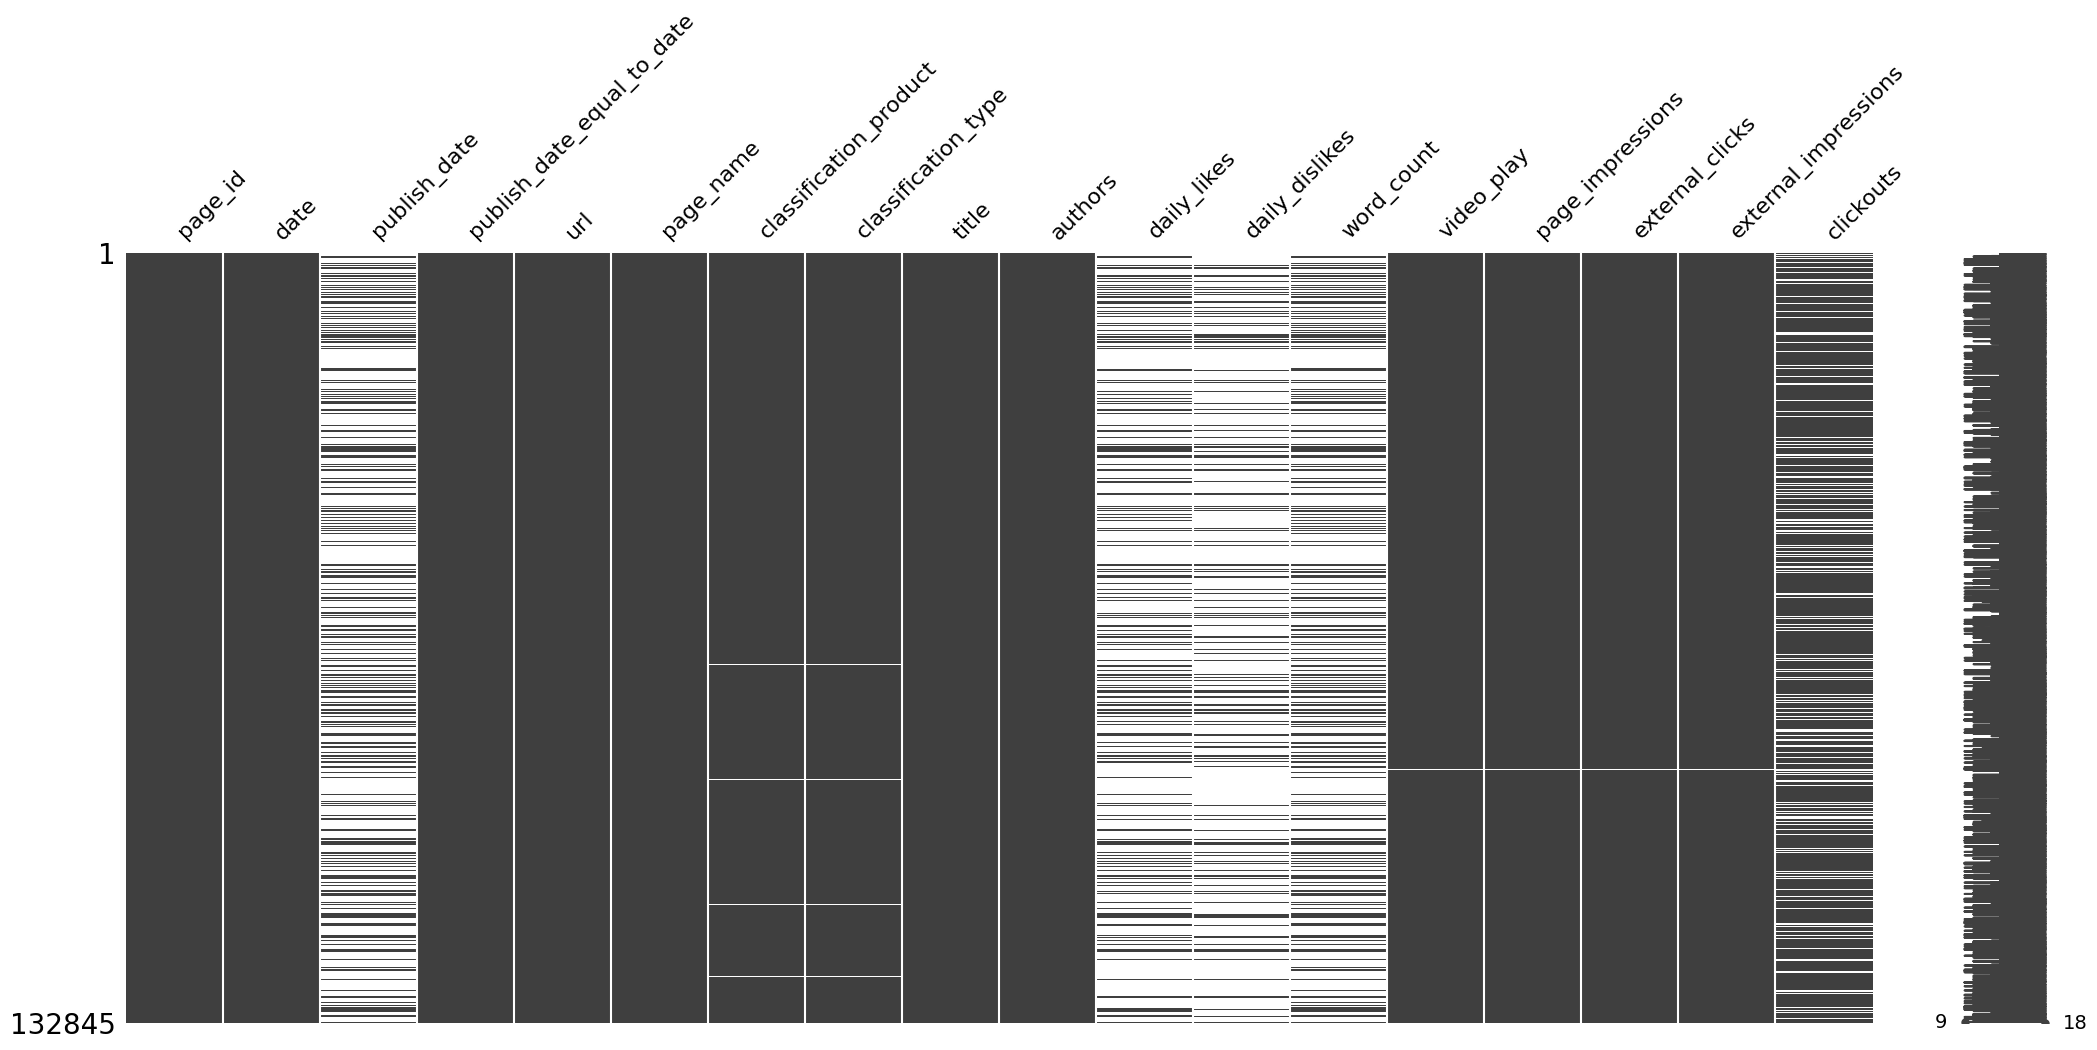

In [18]:
mgn.matrix(df);

Cleaning up

In [19]:
del df1
del df2

## Imputing

In [20]:
df = df.sort_values(['page_id', 'date', 'publish_date', 'url']).reset_index(drop=True)

In [32]:
article10437 = df[df.page_id == 10437]
article10437.shape

(254, 18)

In [30]:
article10437.loc[article10437.date < article10437.publish_date, 'publish_date']# = pd.Timestamp('2018-01-01 00:00:00')

Series([], Name: publish_date, dtype: datetime64[ns])

In [37]:
versions2_10437 = article10437.groupby(['page_id'], as_index=False, sort=True)[
    ['page_id', 'date', 'publish_date', 'word_count']
    ].ffill().drop_duplicates(['page_id', 'date', 'publish_date'])
versions2_10437

,page_id,date,publish_date,word_count
65,10437,2023-01-01,NaT,NaN
67,10437,2023-01-02,NaT,NaN
68,10437,2023-01-03,NaT,NaN
69,10437,2023-01-04,NaT,NaN
72,10437,2023-01-05,NaT,NaN
...,...,...,...,...
302,10437,2024-02-21,2024-02-19,2314.0
306,10437,2024-02-22,2024-02-19,2314.0
309,10437,2024-02-23,2024-02-19,2314.0
312,10437,2024-02-25,2024-02-19,2314.0


In [42]:
temp = pd.merge(article10437.drop(['publish_date', 'word_count'], axis=1).drop_duplicates(['page_id', 'date', 'url', 'authors']), 
                versions2_10437,
         on=['page_id', 'date'], how='inner')
temp

,page_id,date,publish_date_equal_to_date,url,page_name,classification_product,classification_type,title,authors,daily_likes,daily_dislikes,video_play,page_impressions,external_clicks,external_impressions,clickouts,publish_date,word_count
0,10437,2023-01-01,N,https://efahrer.chip.de/e-wissen/die-guenstigsten-e-autos-2022-smart-fiat-und-co-ab-13000-euro_10437,efa-10437 | E-Autos ab 10.000 Euro: Diese günstigen Elektroautos gibt's schon heute,E-Auto,Kaufberatung,E-Autos ab 10.000 Euro: Diese günstigen Elektroautos gibt's schon heute,Moritz Diethelm & Dominik Zarychta,NaN,NaN,0.0,3.0,116.0,7963.0,0.0,NaT,NaN
1,10437,2023-01-01,N,https://efahrer.chip.de/news/trotz-schmelzender-foerderung-das-sind-auch-2023-die-guenstigsten-e-autos_10437,efa-10437 | E-Autos ab 10.000 Euro: Diese günstigen Elektroautos gibt's schon heute,E-Auto,Kaufberatung,E-Autos ab 10.000 Euro: Diese günstigen Elektroautos gibt's schon heute,Moritz Diethelm & Dominik Zarychta,NaN,NaN,336.0,5557.0,116.0,7963.0,158.0,NaT,NaN
2,10437,2023-01-02,N,https://efahrer.chip.de/news/trotz-schmelzender-foerderung-das-sind-auch-2023-die-guenstigsten-e-autos_10437,efa-10437 | E-Autos ab 10.000 Euro: Diese günstigen Elektroautos gibt's schon heute,E-Auto,Kaufberatung,E-Autos ab 10.000 Euro: Diese günstigen Elektroautos gibt's schon heute,Moritz Diethelm & Dominik Zarychta,NaN,NaN,176.0,1939.0,30.0,1293.0,58.0,NaT,NaN
3,10437,2023-01-03,N,https://efahrer.chip.de/news/trotz-schmelzender-foerderung-das-sind-auch-2023-die-guenstigsten-e-autos_10437,efa-10437 | E-Autos ab 10.000 Euro: Diese günstigen Elektroautos gibt's schon heute,E-Auto,Kaufberatung,E-Autos ab 10.000 Euro: Diese günstigen Elektroautos gibt's schon heute,Moritz Diethelm & Dominik Zarychta,NaN,NaN,115.0,733.0,10.0,304.0,27.0,NaT,NaN
4,10437,2023-01-04,N,https://efahrer.chip.de/e-wissen/die-guenstigsten-e-autos-2022-smart-fiat-und-co-ab-13000-euro_10437,efa-10437 | E-Autos ab 10.000 Euro: Diese günstigen Elektroautos gibt's schon heute,E-Auto,Kaufberatung,E-Autos ab 10.000 Euro: Diese günstigen Elektroautos gibt's schon heute,Moritz Diethelm & Dominik Zarychta,NaN,NaN,0.0,2.0,8.0,161.0,0.0,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,10437,2024-02-25,N,https://efahrer.chip.de/news/hersteller-druecken-die-preise-nach-bafa-aus-ihr-e-neuwagen-schon-ab-13000-euro_10437,efa-10437 | E-Autos ab 10.000 Euro: Diese günstigen Elektroautos gibt's schon heute,E-Auto,Kaufberatung,E-Autos ab 10.000 Euro: Diese günstigen Elektroautos gibt's schon heute,Dominik Zarychta & Benjamin Dizdar,3.0,1.0,0.0,2.0,133.0,2241.0,0.0,2024-02-19,2314.0
250,10437,2024-02-25,N,https://efahrer.chip.de/news/preisschlacht-nach-dem-ende-der-praemie-nun-gibt-es-e-neuwagen-ab-13000-euro_10437,efa-10437 | E-Autos ab 10.000 Euro: Diese günstigen Elektroautos gibt's schon heute,E-Auto,Kaufberatung,E-Autos ab 10.000 Euro: Diese günstigen Elektroautos gibt's schon heute,Dominik Zarychta & Benjamin Dizdar,3.0,1.0,0.0,4.0,133.0,2241.0,0.0,2024-02-19,2314.0
251,10437,2024-02-26,N,https://efahrer.chip.de/news/autobauer-liefern-sich-rabattschlacht-guenstige-e-autos-gibt-es-ab-13000-euro_10437,efa-10437 | E-Autos ab 10.000 Euro: Diese günstigen Elektroautos gibt's schon heute,E-Auto,Kaufberatung,E-Autos ab 10.000 Euro: Diese günstigen Elektroautos gibt's schon heute,Dominik Zarychta & Benjamin Dizdar,5.0,2.0,116.0,2163.0,94.0,1392.0,158.0,2024-02-19,2314.0
252,10437,2024-02-26,N,https://efahrer.chip.de/news/guenstiger-als-vor-dem-ende-der-foerderung-e-autos-ab-rund-13000-euro_10437,efa-10437 | E-Autos ab 10.000 Euro: Diese günstigen Elektroautos gibt's schon heute,E-Auto,Kaufberatung,E-Autos ab 10.000 Euro: Diese günstigen Elektroautos gibt's schon heute,Dominik Zarychta & Benjamin Dizdar,5.0,2.0,0.0,1.0,94.0,1392.0,0.0,2024-02-19,2314.0


#### Article versions

In [ ]:
df[(df['publish_date_equal_to_date'] == 'Y') & (df['publish_date'].isna())]

Attention: some articles were scheduled for an update (or first publication), therefore have already existing entries and stats (likes, dislikes, etc.)

In [ ]:
scheduled_articles = df.query('date < publish_date')#[df.columns.drop(['url', 'title', 'page_name'])]

In [ ]:
scheduled_articles_ids = scheduled_articles.page_id.unique()

In [ ]:
df.columns

In [ ]:
# Grouping, so we are not filling in the values from other articles!
versions = df.groupby(['page_id'], as_index=False, sort=True)[
    ['page_id', 'date', 'publish_date', 'word_count']
    ].ffill()
#versions.rename({'index': 'page_id'}, axis=1, inplace=True)
versions

In [ ]:
versions.query('date < publish_date').shape[0] == scheduled_articles.shape[0]

In [ ]:
wtf_idx = versions.query('date < publish_date').index.difference(scheduled_articles.index)
wtf_idx

<font color=red> We'll assume that all articles which don't have a publishing date but were scheduled for an update are actually REALLY OLD and were published at the around inception of EFAHRER (01-01-2018) </font>

In [ ]:
df.loc[df.date < df.publish_date, 'publish_date'] = pd.Timestamp('2018-01-01 00:00:00')

For some pages we simply don't know the date of first publication! We need to impute it for modelling.
Which articles are those?

In [ ]:
no_publ_date = versions[versions.publish_date.isna()].page_id.unique()
no_publ_date

In [ ]:
no_publ_date.shape 

In [ ]:
len(no_publ_date) / len(df.page_id.unique())

So those entries comprise almost 34 % of all articles :(

**For those we apply the same imputing**

In [ ]:
df.loc[df.page_id.isin(no_publ_date), 'publish_date'] = pd.Timestamp('2018-01-01 00:00:00')

<font color=red> Assuming that when the word counts do not change unless ptherwise specified </font>

In [ ]:
versions2 = df.groupby(['page_id'], as_index=False, sort=True)[
    ['page_id', 'date', 'publish_date', 'word_count']
    ].ffill().drop_duplicates()

versions2

In [ ]:
versions[(versions.date < versions.publish_date)]

Merging the imputed columns back in:

In [ ]:
versions2.columns

In [ ]:
df.columns.drop('publish_date').drop('word_count')

In [ ]:
df_imputed = pd.merge(df[df.columns.drop('publish_date').drop('word_count')], # drop the non-imputed columns
                      versions2,
                      on=['page_id', 'date'], how='left')

In [ ]:
mgn.matrix(df_imputed)

#### Daily reactions

In [ ]:
df['daily_likes']

### Merging in the scraped data

Thanks Clara

In [ ]:
df_scraped = pd.read_csv('../data/scraping_no_duplicates.csv')
df_scraped.columns = [col.lower() for col in df_scraped.columns]

df_scraped.rename({
           #'impressions': 'page_impressions',
           'words': 'words_scraped',
           'page_efahrer_id': 'page_id',
           'page_canonical_url': 'url',
           'author': 'author_scraped',
           'current_title': 'h1'
            }, axis=1, inplace=True)

col_to_merge = ['page_id', 'url']
df_full = pd.merge(left=df, right=df_scraped, on=col_to_merge, how='left')

In [ ]:
df_full = df_full.drop('publish_date_equal_to_date', axis=1)

In [ ]:
mgn.matrix(df_full);

In [ ]:
df_full = df_full.sort_values(['page_id', 'date', 'publish_date'])

### Imputing (again)

<font color=red> Imputing with forward-fill </font>
<font color=red> Impute word counts with 0 </font> 

-> In the future: take the value of the `word count (scraped)` or the mean value for the given category! 

In [ ]:
df_full['word_count'] = df_full.groupby(['page_id', 'date'])['word_count'].ffill()
df_full['word_count'] = df_full['word_count'].fillna(0)

df_full['publish_date'] = df_full.groupby(['page_id', 'date'])['publish_date'].ffill()
df_full['publish_date'] = df_full.groupby(['page_id'])['publish_date'].ffill()

---

# Aggregating 

For using in subprojects

In [ ]:
page_unique_features = ['page_id', 'publish_date', 'word_count', 'authors']

In [ ]:
df_full.columns

In [ ]:
(df_full[page_unique_features + ['date']].drop_duplicates().value_counts() > 1).sum()

this means they are really unique

#### Versions

In [ ]:
#df_versions['version_n'] = 
temp = df_full[['page_id', 'word_count', 'publish_date', 'authors']].drop_duplicates()
temp = temp.fillna({'word_count': 0, 'publish_date': pd.Timestamp('2018-01-01 00:00')})
temp = temp.drop_duplicates()
temp = temp.sort_values('publish_date')

In [ ]:
wc_versions = temp.groupby('page_id')['word_count'].transform(lambda x: pd.factorize(x)[0])
publish_versions = temp.groupby('page_id')['publish_date'].transform(lambda x: pd.factorize(x)[0])
authors_versions = temp.groupby('page_id')['authors'].transform(lambda x: pd.factorize(x)[0])

In [ ]:
version_count = 1000*wc_versions + 100*publish_versions + 1*authors_versions
temp['ver_id_wc'] = wc_versions
temp['ver_id_pub'] = publish_versions
temp['ver_id_auth'] = authors_versions
temp['version_id_raw'] = version_count
#version_count = pd.factorize(version_count)[0]

In [ ]:
temp['version_id'] = temp.groupby('page_id')['version_id_raw'].transform(lambda x: pd.factorize(x)[0])

In [ ]:
df_full_versions = pd.merge(df_full, temp.drop(['ver_id_wc', 'ver_id_pub', 'ver_id_auth', 'version_id_raw'], axis=1),
         on=['page_id', 'word_count', 'publish_date', 'authors'],
         how='left')

In [ ]:
# df_full_versions['word_count'] = df_full_versions.groupby('page_id')['word_count'].fillna(0)

### User-side

User side features: those which the reader sees

In [ ]:
user_side_features = ['page_id', 'date', 'publish_date', 'word_count', 'words_scraped', 
                    'page_title', 'page_name', 'title', 'h1', 'authors',  
                    'classification_product', 'classification_type']

---

## Feature engineering

### Article (content) versions

We want to label each version.
* Version changes when there is a new `publication date`
* Version changes when there is a new `word count`
* Version does NOT change with a change in `URL`
* Version does NOT change with a change in the `date` column

In [ ]:
# Only the necessary columns
# we still need the 'date' column for imputation
df_cnt = df[['page_efahrer_id', 'date', 'published_at', 'word_count']]
df_cnt = df_cnt.sort_values(['page_efahrer_id', 'date', 'published_at'])
df_cnt

In [ ]:
mgn.matrix(df_cnt);

There are some columns where the publication date changed but the `word count` was not updated!

In [ ]:
wcna_idx = df_cnt[df_cnt.word_count.isna() & df_cnt.published_at.notna()].index
wcna_idx

NOT the other way around:

In [ ]:
df_cnt[df_cnt.word_count.notna() & df_cnt.published_at.isna()].index

The best assumption that it did not change (significantly??), so still forward-fill it.

In [ ]:
df_cnt = df_cnt.ffill()

In [ ]:
sus = df_cnt.loc[wcna_idx]

#### Versions

In [ ]:
df_cnt['publ_at_enc'] = df_cnt.groupby('page_efahrer_id')['published_at'].transform(lambda x: pd.factorize(x)[0])
df_cnt

How many versions does each article have?

In [ ]:
to_plot = df_cnt[['page_efahrer_id', 'publ_at_enc']].groupby('page_efahrer_id').max()#.reset_index()
first_publ_date = df_cnt[['page_efahrer_id', 'published_at']].groupby('page_efahrer_id').min()
first_publ_date = first_publ_date.rename({'published_at': 'First publication date'}, axis=1)
to_plot = to_plot.join(first_publ_date)
to_plot = to_plot.rename({'publ_at_enc': 'Number of versions'}, axis=1)
to_plot

In [ ]:
px.scatter(data_frame=to_plot, x='Number of versions', y='First publication date')

Article with 61 (!!!) versions: 105259

In [ ]:
metrics_cols = ['page_canonical_url', 'daily_likes', 
               'daily_dislikes', 'impressions', 'video_play', 
               'discover_clicks', 'discover_impressions']

In [ ]:
article105259 = df[df['page_efahrer_id']==105259].sort_values(['date', 'page_canonical_url'])
article_first_url = article105259[metrics_cols + ['date']].drop_duplicates(subset=['date'], keep='first')

In [ ]:
import matplotlib.pyplot as plt

xticks=pd.date_range(df.date.min(), df.date.max(), freq='2M')
fig = article_first_url.plot(kind='bar', x='date', y=metrics_cols, subplots=True, figsize=(6, 12), 
                       xticks=xticks)
plt.gca().set_xticklabels([x.strftime('%a\n%d\n%h\n%Y') for x in xticks]);
#plt.xticks(ticks=df[['impressions', 'published_at']].resample('W', on='published_at').max().index);
#plt.xticks(ticks=pd.date_range(df.date.min(), df.date.max(), freq='2M'),
#           labels=pd.date_range(df.date.min(), df.date.max(), freq='2M'));

In [ ]:
df_full = pd.read_csv('../data/full_data.csv')
df_full